# DATA SCIENCE INTERN @ CODERS CAVE

### AUTHOR : PARVEJ ALAM M. ANSARI

## Task_4: Speech Emotion Recognition

### The dataset is available at Kaggle :
### https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition/input

### About Sppech Emotion Recognition:

#### Speech Emotion Recognition (SER).
* Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion.

#### Why do we need it?

1. Emotion recognition is the part of speech recognition which is gaining more popularity and need for it increases enormously. Although there are methods to recognize emotion using machine learning techniques, this project attempts to use deep learning to recognize the emotions from data.

2. SER(Speech Emotion Recognition) is used in call center for classifying calls according to emotions and can be used as the performance parameter for conversational analysis thus identifying the unsatisfied customer, customer satisfaction and so on.. for helping companies improving their services

3. It can also be used in-car board system based on information of the mental state of the driver can be provided to the system to initiate his/her safety preventing accidents to happen

## 1. Import required libraries

In [2]:
# !pip install librosa

In [3]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ansariparvejalam","key":"4411d7bbf0efdc17430d1c0f7a5d8726"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio -p /content
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee -p /content

 99% 424M/429M [00:07<00:00, 50.8MB/s]
100% 429M/429M [00:07<00:00, 60.7MB/s]
 95% 102M/107M [00:02<00:00, 32.6MB/s] 
100% 107M/107M [00:02<00:00, 43.5MB/s]


In [7]:
!unzip /content/ravdess-emotional-speech-audio.zip -d /content/ravdess
!unzip /content/surrey-audiovisual-expressed-emotion-savee.zip -d /content/savee

Archive:  /content/ravdess-emotional-speech-audio.zip
  inflating: /content/ravdess/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: /content/

## 2. Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [8]:
# Paths for data.
Ravdess = "/content/ravdess/audio_speech_actors_01-24/"
Savee = "/content/savee/ALL/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [9]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0     angry  /content/ravdess/audio_speech_actors_01-24/Act...
1     angry  /content/ravdess/audio_speech_actors_01-24/Act...
2      calm  /content/ravdess/audio_speech_actors_01-24/Act...
3   disgust  /content/ravdess/audio_speech_actors_01-24/Act...
4  surprise  /content/ravdess/audio_speech_actors_01-24/Act...

In [10]:
Ravdess_df.shape

(1440, 2)

##  <center> 2. CREMA-D dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [11]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                            Path
0  disgust   /content/savee/ALL/JK_d02.wav
1     fear   /content/savee/ALL/JK_f13.wav
2      sad  /content/savee/ALL/JE_sa06.wav
3    angry   /content/savee/ALL/JE_a01.wav
4     fear   /content/savee/ALL/KL_f05.wav

In [12]:
Savee_df.shape

(480, 2)

In [13]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0     angry  /content/ravdess/audio_speech_actors_01-24/Act...
1     angry  /content/ravdess/audio_speech_actors_01-24/Act...
2      calm  /content/ravdess/audio_speech_actors_01-24/Act...
3   disgust  /content/ravdess/audio_speech_actors_01-24/Act...
4  surprise  /content/ravdess/audio_speech_actors_01-24/Act...

## 3. Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

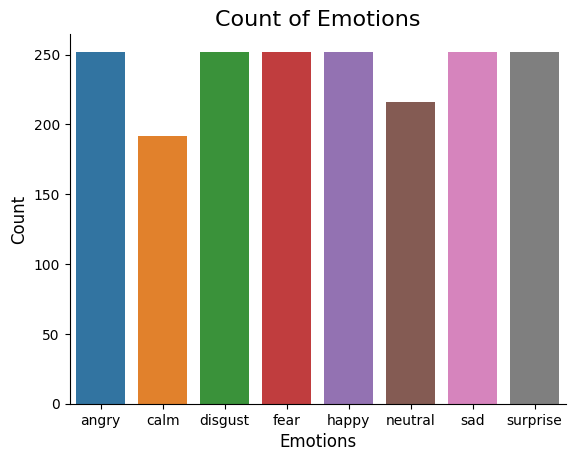

In [14]:
data_path['Emotions'] = data_path['Emotions'].astype('category')

plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [15]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(data)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

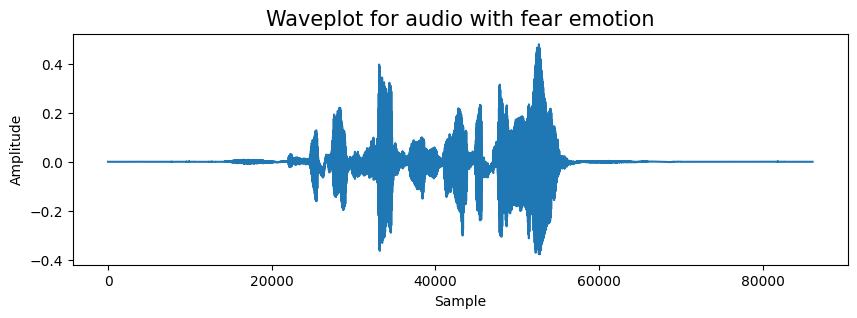

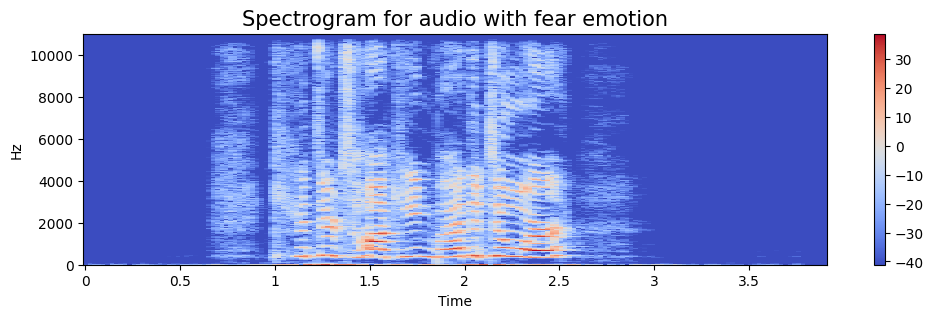

In [16]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

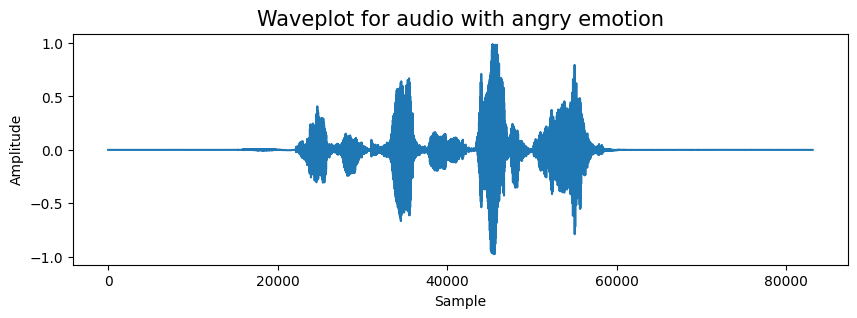

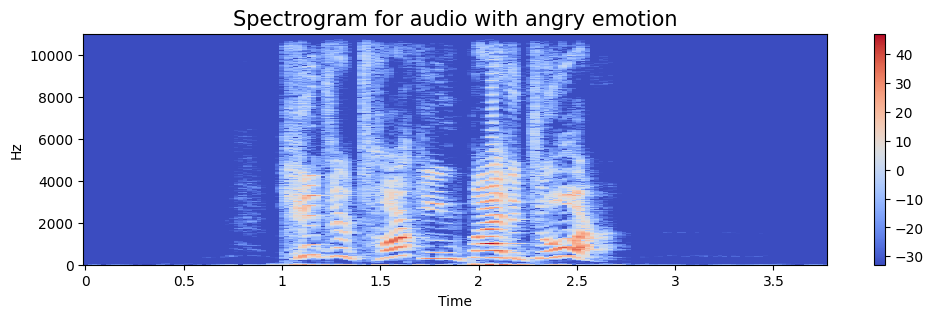

In [17]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

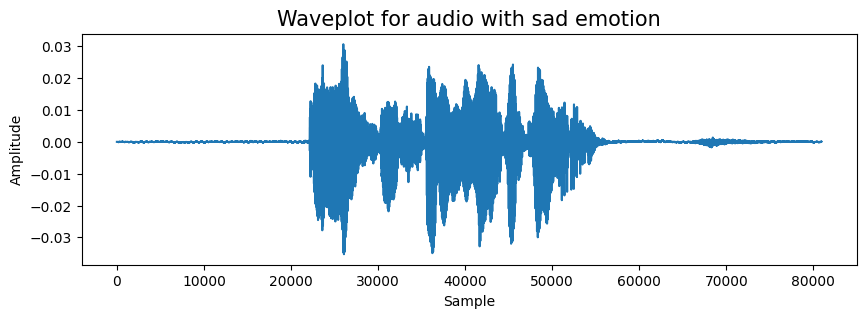

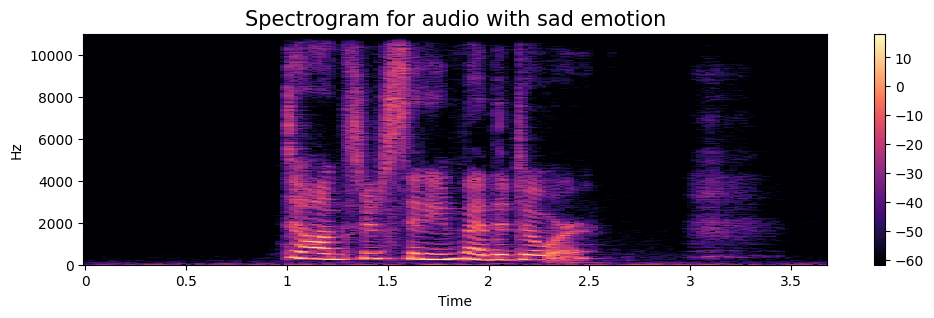

In [18]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

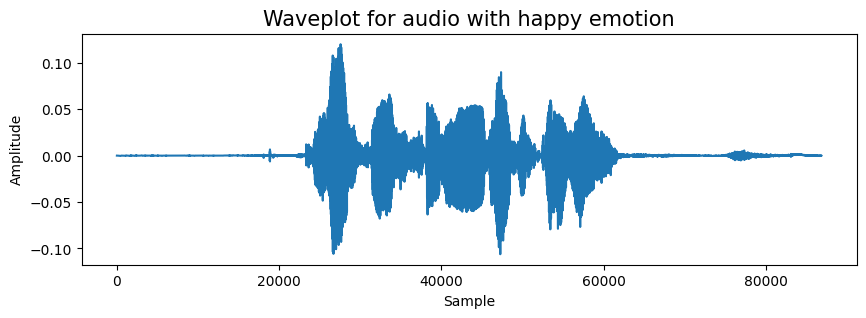

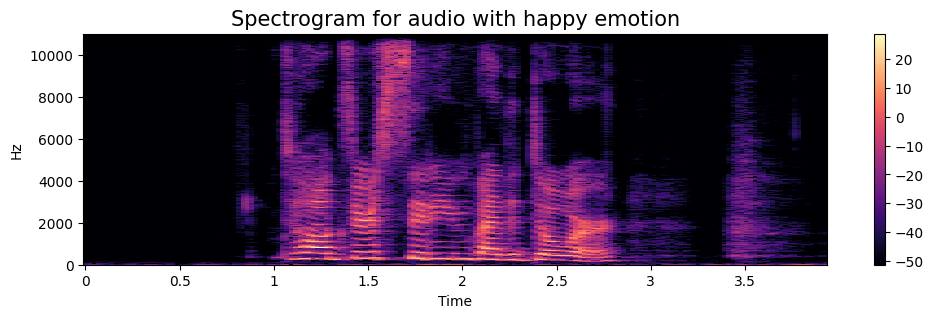

In [19]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## 4. Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [20]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    if pitch_factor <= 0:
        raise ValueError("pitch_factor must be a positive number")

    pitched = librosa.effects.time_stretch(data, rate=1.0 / pitch_factor)
    return pitched

# taking any example and checking for techniques.
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)

#### 1. Simple Audio

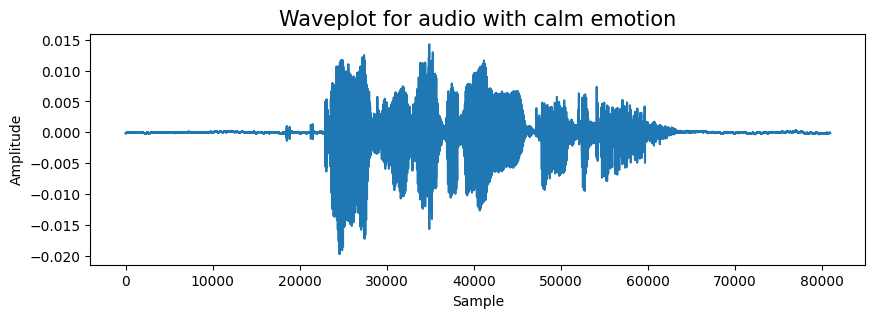

In [21]:
emotion='calm'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
Audio(path)

#### 2. Noise Injection

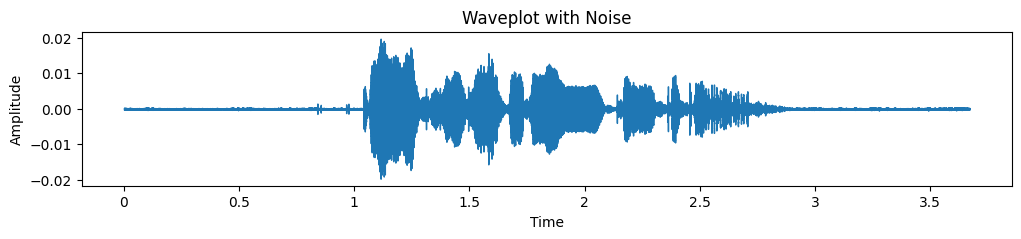

In [22]:
emotion='calm'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
x = noise(data)

# Plot the waveplot with noise
plt.figure(figsize=(12, 2))
librosa.display.waveshow(y=x, sr=sampling_rate)
plt.title('Waveplot with Noise')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Play the audio with noise
Audio(x, rate=sampling_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

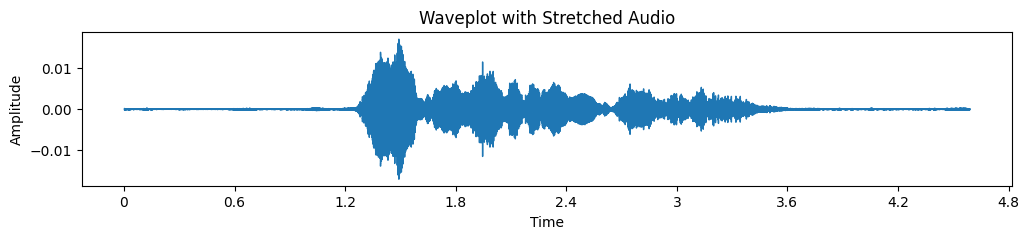

In [23]:
emotion = 'calm'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
x = stretch(data)

# Plot the waveplot with stretched audio
plt.figure(figsize=(12, 2))
librosa.display.waveshow(y=x, sr=sampling_rate)
plt.title('Waveplot with Stretched Audio')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Play the stretched audio
from IPython.display import Audio
Audio(x, rate=sampling_rate)

#### 4. Shifting

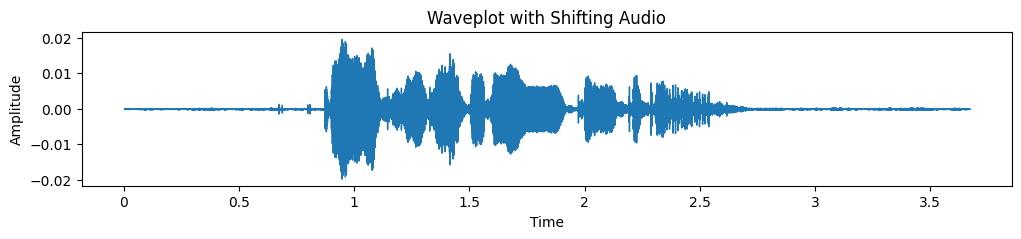

In [24]:
emotion = 'calm'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
x = shift(data)

# Plot the waveplot with stretched audio
plt.figure(figsize=(12, 2))
librosa.display.waveshow(y=x, sr=sampling_rate)
plt.title('Waveplot with Shifting Audio')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Play the stretched audio
Audio(x, rate=sampling_rate)

### 5. Pitch

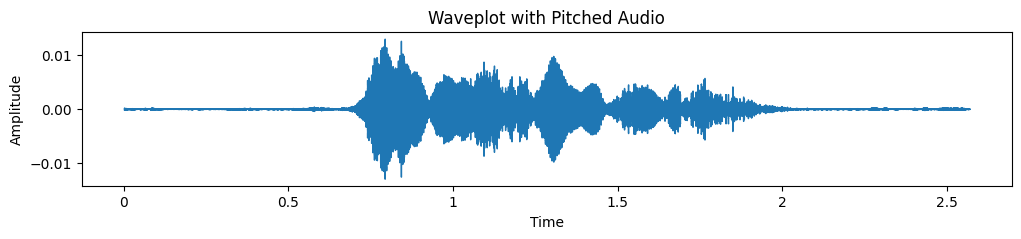

In [25]:
emotion = 'calm'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
x = pitch(data, sampling_rate, pitch_factor=0.7)

# Plot the waveplot with stretched audio
plt.figure(figsize=(12, 2))
librosa.display.waveshow(y=x, sr=sampling_rate)
plt.title('Waveplot with Pitched Audio')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Play the stretched audio
Audio(x, rate=sampling_rate)

- From the above types of augmentation techniques I am using noise, stretching(ie. changing speed) and some pitching.

## 5. Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [26]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [27]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [29]:
len(X), len(Y), data_path.Path.shape

(5760, 5760, (1920,))

In [30]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.155631  0.652999  0.614690  0.653589  0.641073  0.562788  0.488316   
1  0.324784  0.741721  0.733663  0.763649  0.773999  0.717428  0.594919   
2  0.151110  0.640881  0.576177  0.640600  0.646413  0.543148  0.438632   
3  0.129517  0.552897  0.561556  0.598754  0.608615  0.639215  0.608321   
4  0.276688  0.662571  0.674502  0.719035  0.738377  0.765779  0.677386   

          7         8         9  ...       153       154       155       156  \
0  0.550705  0.546261  0.492733  ...  0.003187  0.006627  0.007594  0.010936   
1  0.613792  0.594768  0.591130  ...  0.013801  0.017456  0.017788  0.021098   
2  0.492303  0.510908  0.451822  ...  0.000704  0.001242  0.001533  0.002412   
3  0.656219  0.664895  0.627405  ...  0.003322  0.003462  0.003704  0.004251   
4  0.624204  0.638631  0.658197  ...  0.007037  0.006986  0.007674  0.007938   

        157       158       159       160       161  labels  
0  0.013340  0.013784  0.010417  0.004836  0.000282   angry  
1  0.024521  0.025012  0.022503  0.014991  0.011259   angry  
2  0.002613  0.002666  0.002433  0.001014  0.000063   angry  
3  0.003684  0.003738  0.003109  0.001720  0.000167   angry  
4  0.007171  0.007461  0.007090  0.005480  0.003731   angry  

[5 rows x 163 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

## 6. Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [31]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [32]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [33]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 162), (4320, 8), (1440, 162), (1440, 8))

In [34]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 162), (4320, 8), (1440, 162), (1440, 8))

In [35]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 162, 1), (4320, 8), (1440, 162, 1), (1440, 8))

## 7. Modelling

In [36]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [37]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
68/68 [==============================] - 28s 383ms/step - loss: 2.0163 - accuracy: 0.1852 - val_loss: 1.9651 - val_accuracy: 0.2292 - lr: 0.0010
Epoch 2/50
68/68 [==============================] - 27s 391ms/step - loss: 1.9557 - accuracy: 0.2264 - val_loss: 1.8514 - val_accuracy: 0.2799 - lr: 0.0010
Epoch 3/50
68/68 [==============================] - 26s 376ms/step - loss: 1.8741 - accuracy: 0.2613 - val_loss: 1.7618 - val_accuracy: 0.3139 - lr: 0.0010
Epoch 4/50
68/68 [==============================] - 25s 375ms/step - loss: 1.7996 - accuracy: 0.2891 - val_loss: 1.7074 - val_accuracy: 0.3569 - lr: 0.0010
Epoch 5/50
68/68 [==============================] - 28s 407ms/step - loss: 1.7455 - accuracy: 0.3178 - val_loss: 1.6772 - val_accuracy: 0.3674 - lr: 0.0010
Epoch 6/50
68/68 [==============================] - 28s 413ms/step - loss: 1.6844 - accuracy: 0.3530 - val_loss: 1.6087 - val_accuracy: 0.3708 - lr: 0.0010
Epoch 7/50
68/68 [==============================] - 26s 387ms/st

45/45 [==============================] - 2s 40ms/step - loss: 1.0226 - accuracy: 0.7118
Accuracy of our model on test data :  71.18055820465088 %


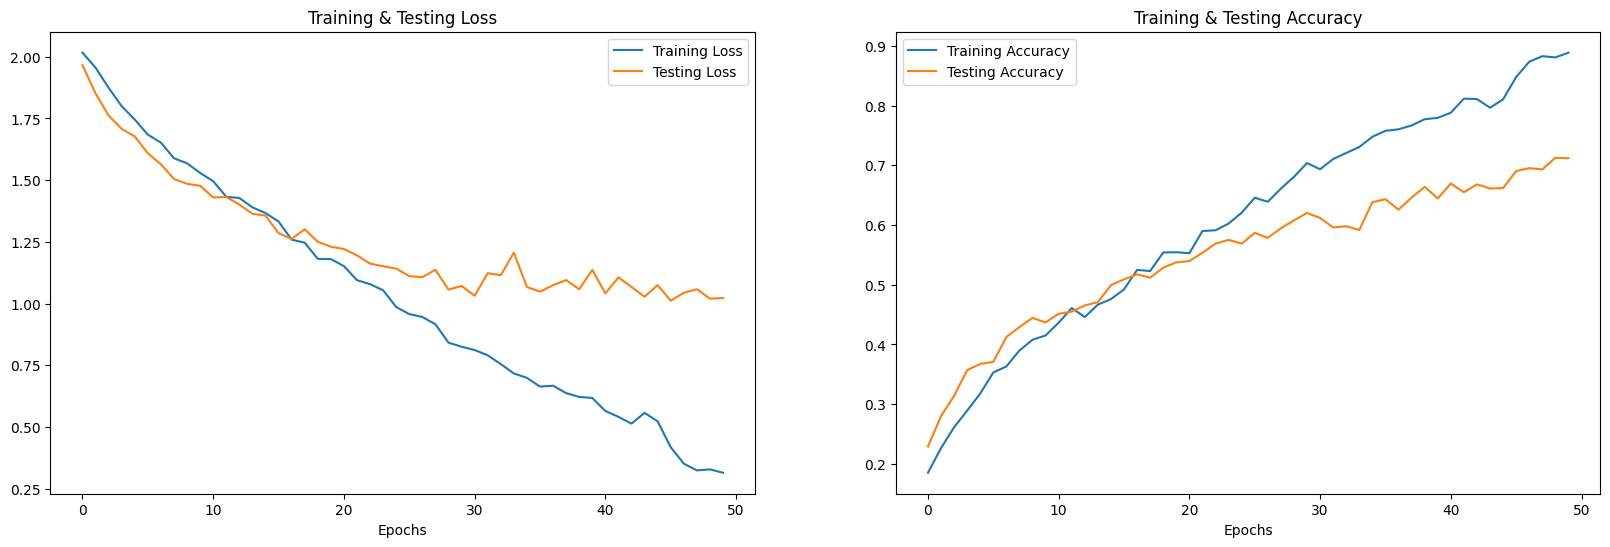

In [38]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [39]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

45/45 [==============================] - 2s 39ms/step


In [40]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0         surprise      surprise
1          disgust          fear
2         surprise      surprise
3            angry          fear
4          neutral       neutral
5             fear      surprise
6              sad           sad
7            angry         angry
8            happy         happy
9          neutral       neutral

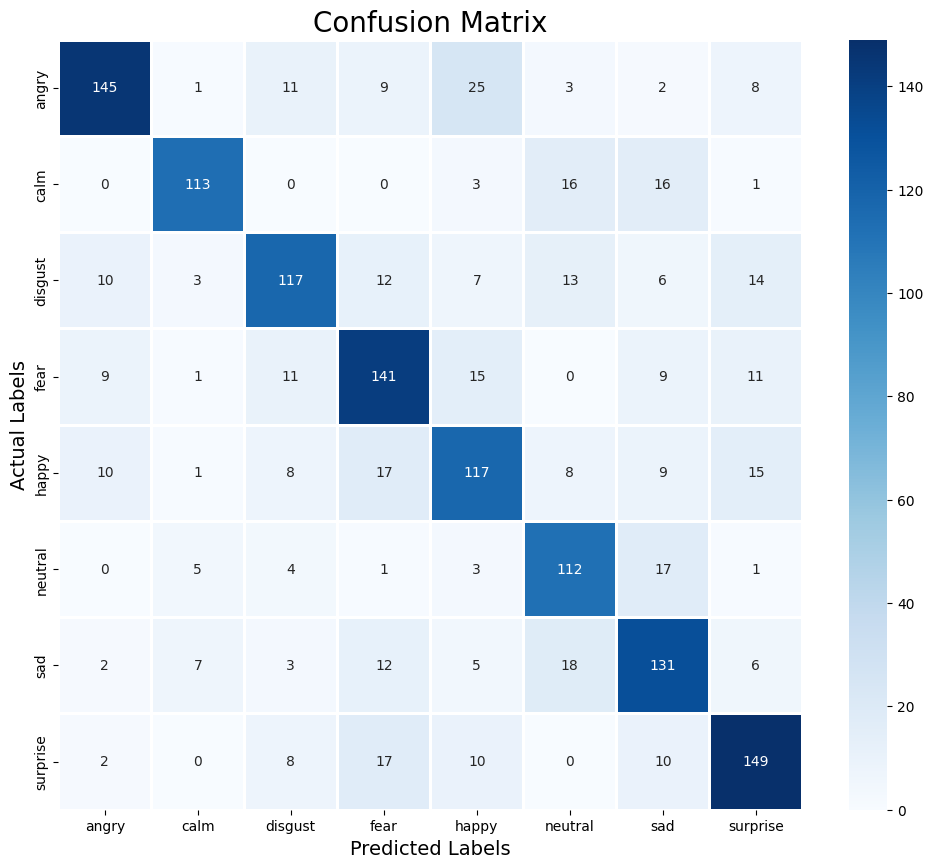

In [41]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.81      0.71      0.76       204
        calm       0.86      0.76      0.81       149
     disgust       0.72      0.64      0.68       182
        fear       0.67      0.72      0.69       197
       happy       0.63      0.63      0.63       185
     neutral       0.66      0.78      0.72       143
         sad       0.66      0.71      0.68       184
    surprise       0.73      0.76      0.74       196

    accuracy                           0.71      1440
   macro avg       0.72      0.71      0.71      1440
weighted avg       0.72      0.71      0.71      1440



- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 71% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.

<p style="background-color:#F1C40F;color:black;font-size:22px;text-align:center;border-radius:10px 10px;font-weight:bold;border:2px solid #F1C40F;">Thank you😄!!!!!!</p>